<a href="https://colab.research.google.com/github/pearl-yu/twitch_project/blob/main/10112022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## Run this line if using Colab.
!git clone https://github.com/pearl-yu/twitch_project
%cd twitch_project/

Cloning into 'twitch_project'...
remote: Enumerating objects: 80, done.
remote: Counting objects: 100% (80/80), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 80 (delta 37), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (80/80), done.
/content/twitch_project


In [ ]:
## So we can write the dataset to google drive (not github. need to upload to github manually.) (not for now.)
## from google.colab import drive
## drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import requests  # get the content from the API by using the get() method. json() method converts the API response to JSON format for easy handling.
import json   # to work with the returned json content from API.
import numpy as np
import pandas as pd

from pandas import json_normalize

import matplotlib.pyplot as plt

from datetime import datetime
import re

In [ ]:
## Pearl's credentials
client_id = 'tamrylbvlu3wub4r8c5fddwsou246x'
client_secret= 'y4enh38kpiwkh7j00nqvv185ttsedw'

# Defining the URL to which we will make the request
url = 'https://id.twitch.tv/oauth2/token'
# Defining the parameters to be passed to the request
body = {
  'client_id'     : client_id,
  'client_secret' : client_secret,
  'grant_type'    : 'client_credentials'
}

access_code = requests.post(url, params=body) # Making a POST request to the URL to retrieve the access token
access_token = json.loads(access_code.text) #access token response is a JSON-encoded app access token

access_token = access_token['access_token']

With the sample:
- Pull user ids by calling the https://dev.twitch.tv/docs/api/reference#get-users endpoint, specifying the login parameter.
- Pull the video ids following this: https://github.com/btjmga/twitch-getallvods  (I didn't have the code to pull ALL the vids)
- Pull the chatfiles of these videos. (using the downloader https://github.com/lay295/TwitchDownloader is easy. Check  https://github.com/Chaparro/rechat-dl and https://github.com/malciin/twitch-comments-downloader for code.)
- Construct variables from the chatfile.
- Call what other stuff? 

In [ ]:
# reference - read in multiple files: https://sparkbyexamples.com/pandas/pandas-read-multiple-csv-files/
# Import libraries
import glob

# Get CSV files list from a folder
#path = './data/sample_by_growing_sullygnome'
#csv_files = glob.glob(path + "/*.csv")

# Read each CSV file into DataFrame
#df_list = (pd.read_csv(file) for file in csv_files) # This creates a list of dataframes
#df   = pd.concat(df_list, ignore_index=True) # Concatenate all DataFrames

#df = df.sample(frac=1) # shuffle the order of rows

path = './data/sample_by_growing_sullygnome/Fastest growing Twitch streamers, past 30 days - SullyGnome (7).csv'
df = pd.read_csv(path)

print(df.shape)
df.head()

(100, 13)


,Unnamed: 0,Unnamed: 1,Channel,Watch time (mins),Stream time (mins),Peak viewers,Average viewers,Followers,Followers gained,Partnered,Mature,Language,Unnamed: 12
0,3401,https://static-cdn.jtvnw.net/jtv_user_pictures...,FergyFergTV,53175,2220,124,23,4600,2784,False,True,French,FergyFergTV
1,3402,https://static-cdn.jtvnw.net/jtv_user_pictures...,Cabramaravilla,2200935,1380,2704,1594,38413,2782,True,False,Spanish,Cabramaravilla
2,3403,https://static-cdn.jtvnw.net/jtv_user_pictures...,Riotessa,43395,765,431,56,3803,2782,False,True,Russian,Riotessa
3,3404,https://static-cdn.jtvnw.net/jtv_user_pictures...,Xa3_404,230475,7530,315,30,6125,2781,False,True,Russian,Xa3_404
4,3405,https://static-cdn.jtvnw.net/jtv_user_pictures...,lTaka_,1004940,7680,739,130,30500,2780,False,False,Thai,lTaka_


In [ ]:
def api_info(url = 'https://api.twitch.tv/helix/users?id=', key_series = df['Channel'], n = 5):
    '''
    url is the api URL
    key_series is a pandas series of the keys. check on the API reference page to see what should be the key
    n is the number of keys you wanna pull info from
    '''
    headers = {
            'Authorization' : 'Bearer '+str(access_token),
            'Client-Id' : client_id
        }

    temp_df = pd.DataFrame()
    for i in range(0,n+1) :
        temp_response = requests.get(url+str(key_series[i]), headers=headers)
        # Load the JSON
        temp_response_json = json.loads(temp_response.text)
        if list(temp_response_json.keys())[0] == 'error':
            continue
        else:
            temp_data = temp_response_json['data']
            temp_df_temp = pd.DataFrame.from_dict(json_normalize(temp_data), orient='columns')
        
            frames = [temp_df, temp_df_temp]
            temp_df = pd.concat(frames, ignore_index=True)
    
    print(temp_df.shape)
    print(temp_df.columns)
    
    return temp_df

In [ ]:
## call the get_users end points to retrieve user id
user_df = api_info(url = 'https://api.twitch.tv/helix/users?login=',
         key_series = df['Channel'], 
         n = 50)

print(user_df.shape)
user_df.head()

(50, 10)
Index(['id', 'login', 'display_name', 'type', 'broadcaster_type',
       'description', 'profile_image_url', 'offline_image_url', 'view_count',
       'created_at'],
      dtype='object')
(50, 10)


,id,login,display_name,type,broadcaster_type,description,profile_image_url,offline_image_url,view_count,created_at
0,80660947,fergyfergtv,FergyFergTV,,affiliate,Contact: nfergy22@gmail.com /\ Operations Mana...,https://static-cdn.jtvnw.net/jtv_user_pictures...,https://static-cdn.jtvnw.net/jtv_user_pictures...,35503,2015-01-23T19:52:57Z
1,122691064,cabramaravilla,Cabramaravilla,,partner,Creando el mejor contenido analítico en españo...,https://static-cdn.jtvnw.net/jtv_user_pictures...,https://static-cdn.jtvnw.net/jtv_user_pictures...,1591543,2016-04-25T14:09:18Z
2,84576855,riotessa,Riotessa,,,"!dis, !steam, !boosty, !vkgroup",https://static-cdn.jtvnw.net/jtv_user_pictures...,https://static-cdn.jtvnw.net/jtv_user_pictures...,20271,2015-03-07T07:25:26Z
3,468193828,xa3_404,Xa3_404,,affiliate,Люблю спорт и активный образ жизни. В здоровом...,https://static-cdn.jtvnw.net/jtv_user_pictures...,https://static-cdn.jtvnw.net/jtv_user_pictures...,198704,2019-10-20T10:07:50Z
4,168624415,ltaka_,lTaka_,,partner,,https://static-cdn.jtvnw.net/jtv_user_pictures...,,179078,2017-08-06T16:06:14Z


In [ ]:
## call the get_videos end points to retrieve all video ids of the users
video_df = api_info(url = 'https://api.twitch.tv/helix/videos?user_id=',
         key_series = user_df['id'], 
         n = 5)

print(video_df.shape)
video_df.head()

(85, 17)
Index(['id', 'stream_id', 'user_id', 'user_login', 'user_name', 'title',
       'description', 'created_at', 'published_at', 'url', 'thumbnail_url',
       'viewable', 'view_count', 'language', 'type', 'duration',
       'muted_segments'],
      dtype='object')
(85, 17)


,id,stream_id,user_id,user_login,user_name,title,description,created_at,published_at,url,thumbnail_url,viewable,view_count,language,type,duration,muted_segments
0,1619335587,47276484045,80660947,fergyfergtv,FergyFergTV,Redbull & Mcdo! [24hours]❗️link ❗️paliers Ense...,,2022-10-09T06:51:13Z,2022-10-09T06:51:13Z,https://www.twitch.tv/videos/1619335587,https://static-cdn.jtvnw.net/cf_vods/d1m7jfoe9...,public,985,fr,archive,10h21m0s,None
1,1619238405,47275761421,80660947,fergyfergtv,FergyFergTV,❗️link ❗️paliers Ensemble avec !AcadieStream p...,,2022-10-09T03:41:17Z,2022-10-09T03:41:17Z,https://www.twitch.tv/videos/1619238405,https://static-cdn.jtvnw.net/cf_vods/d1m7jfoe9...,public,28,fr,archive,6m50s,None
2,1618936117,47273229213,80660947,fergyfergtv,FergyFergTV,❗️link ❗️paliers Ensemble avec !AcadieStream p...,,2022-10-08T21:07:17Z,2022-10-08T21:07:17Z,https://www.twitch.tv/videos/1618936117,https://static-cdn.jtvnw.net/cf_vods/d1m7jfoe9...,public,388,fr,archive,6h33m40s,None
3,1618770779,47272285261,80660947,fergyfergtv,FergyFergTV,❗️link ❗️paliers Ensemble avec !AcadieStream p...,,2022-10-08T18:04:04Z,2022-10-08T18:04:04Z,https://www.twitch.tv/videos/1618770779,https://static-cdn.jtvnw.net/cf_vods/d1m7jfoe9...,public,128,fr,archive,3h2m50s,None
4,1618629121,47271541373,80660947,fergyfergtv,FergyFergTV,❗️link ❗️paliers Ensemble avec !AcadieStream p...,,2022-10-08T15:19:46Z,2022-10-08T15:19:46Z,https://www.twitch.tv/videos/1618629121,https://static-cdn.jtvnw.net/cf_vods/d1m7jfoe9...,public,174,fr,archive,2h41m40s,None


In [ ]:
# Some pre-processing of the video_df
video_df['created_at'] = pd.to_datetime(video_df['created_at']) 
video_df['duration_min'] = video_df['duration'].str.replace("h", '*60').str.replace('m','*1').str.replace('s','*(1/60)').str.replace(' ','+').apply(eval) # convert duration to numeric in minutes

In [ ]:
# Get some simple statistics
print(video_df['created_at'].min(),video_df['created_at'].max())

video_df.groupby('user_id').agg({'id':'count',
                                 'language':'first',
                                 'created_at': [min,max],
                                 'duration_min':[min,max,'mean'],
                                 'view_count':'mean'})

2020-12-10 04:29:00+00:00 2022-10-11 07:10:42+00:00


id language                created_at                            \
          count    first                       min                       max   
user_id                                                                        
122691064    20       es 2021-06-02 15:13:23+00:00 2022-10-11 07:10:42+00:00   
168624415    13       th 2022-09-28 05:19:09+00:00 2022-10-09 09:08:36+00:00   
36266801     20       pt 2022-09-25 11:13:25+00:00 2022-10-11 01:00:09+00:00   
468193828    15       ru 2022-09-28 09:47:09+00:00 2022-10-10 16:02:44+00:00   
80660947     17       fr 2020-12-10 04:29:00+00:00 2022-10-09 06:51:13+00:00   

          duration_min                                view_count  
                   min            max          mean         mean  
user_id                                                           
122691064     0.950000   77231.000000  24208.072500  8330.950000  
168624415    71.533333   77718.666667  43914.275641  9641.538462  
36266801      2.000000  104988.000000  48449.760000  3075.250000  
468193828    80.400000   79232.666667  25135.747778   706.533333  
80660947      0.333333   84462.000000  12952.604902   142.647059

In [ ]:
## retrieve chat files of these videos.
# https://pypi.org/project/chat-downloader/
!pip install chat-downloader  # Need to install this everytime if you're using Colab.
from chat_downloader import ChatDownloader

In [ ]:
## First we take a look at what data there is about the chats
url = video_df['url'][1]
chat = ChatDownloader().get_chat(url)       # create a generator
         # print the formatted message

# For each chat message, this is the full structure
next(chat)

{'message_id': 'a4212063-742b-474b-af6a-70a25d7825da',
 'timestamp': 1665286892922000,
 'time_in_seconds': 14.222,
 'author': {'display_name': 'stephanokc',
  'id': '643788827',
  'name': 'stephanokc',
  'type': 'user',
  'bio': None,
  'created_at': 1612047065271162,
  'images': [{'url': 'https://static-cdn.jtvnw.net/user-default-pictures-uv/cdd517fe-def4-11e9-948e-784f43822e80-profile_image-300x300.png',
    'width': 300,
    'height': 300,
    'id': '300x300'},
   {'url': 'https://static-cdn.jtvnw.net/user-default-pictures-uv/cdd517fe-def4-11e9-948e-784f43822e80-profile_image-70x70.png',
    'width': 70,
    'height': 70,
    'id': '70x70'}]},
 'source': 'chat',
 'state': 'published',
 'message': 'chin shane sort dla piscine',
 'time_text': '0:14',
 'message_type': 'text_message'}

In [ ]:
## First we take a look at what data there is about the chats
url = video_df['url'][0]
chat = ChatDownloader().get_chat(url)       # create a generator
         # print the formatted message

# For each chat message, this is the full structure
next(chat)

{'message_id': '20d5e864-a221-4bb9-908b-40233c17bb2e',
 'timestamp': 1665298566706000,
 'time_in_seconds': 293.006,
 'author': {'display_name': 'FergyFergTV',
  'id': '80660947',
  'name': 'fergyfergtv',
  'type': 'user',
  'bio': "Contact: nfergy22@gmail.com /\\ Operations Manager by Day & Gamer the rest of the time. NB's Acadian. Not the best, but probably the funniest! ;) Love Sports, Beer and Rhum! Come see me play and have a chat. What is love? Oh beer, don't hurt me! Don't hurt me. No more!! #MooseGang. [FR/EN]",
  'created_at': 1422042777072939,
  'images': [{'url': 'https://static-cdn.jtvnw.net/jtv_user_pictures/4f18df1f-aa7d-4ada-8eba-8ea0c29546bd-profile_image-300x300.png',
    'width': 300,
    'height': 300,
    'id': '300x300'},
   {'url': 'https://static-cdn.jtvnw.net/jtv_user_pictures/4f18df1f-aa7d-4ada-8eba-8ea0c29546bd-profile_image-70x70.png',
    'width': 70,
    'height': 70,
    'id': '70x70'}],
  'badges': [{'name': 'broadcaster',
    'version': 1,
    'title': 'B

In [ ]:
# This is a demo of one streamer, 5 messages. 
## Now what do we want to put in a dataframe? 
url = video_df['url'][1]
chat = ChatDownloader().get_chat(url)   

timestamp = []
time_in_seconds = []
messages = []
author_display_name = []
# author_id = []
## Let's hold off the badges and emotes. Those are multi-levels. But they'll be super helpful!!

import itertools

top5 = itertools.islice(chat, 5)

for message in top5:                        # iterate over messages    
    timestamp.append(message['timestamp'])
    time_in_seconds.append(message['time_in_seconds'])
    messages.append(message['message'])
    author_display_name.append(message['author']['display_name'])
    ## better way to flatten. 
    ## can be zipped to a function

#for message in chat:                        # iterate over messages. It's not json!! It's just a dict
#    print(json.dumps(message, indent = 4, sort_keys=True))

chat_df = pd.DataFrame(list(zip(timestamp,time_in_seconds,messages,author_display_name)),
                       columns = ['timestamp','time_in_seconds','messages','author_display_name'])

chat_df.head()
## There're emotes! 

,timestamp,time_in_seconds,messages,author_display_name
0,1665286892922000,14.222,chin shane sort dla piscine,stephanokc
1,1665286915688000,36.988,bye la bonne soireee jvous aiment,NurseScraby
2,1665286956005000,77.305,eille salut les boys !,stephanokc
3,1665286976686000,97.986,Salut la! Jva prob encore cornifler demain si ...,ReactHD9
4,1665286982791000,104.091,oublie pas de temercier l'academie,stephanokc


In [ ]:
# define function to get chat files.
import itertools

def get_chat(key_series = video_df['url'],n = 5, n_message_limit = 100):
  '''
    key_series is a pandas series of video urls.
    n is the number of videos you wanna pull chat from
    n_message_limit is the limit of messages you wanna pull from each video
    '''
  timestamp = []
  time_in_seconds = []
  messages = []
  author_display_name = []
  video_url = []

  for i in range(0,n+1) :
    url = key_series[i]
    chat = ChatDownloader().get_chat(url)   
        
    top = itertools.islice(chat, n_message_limit)
    
    for message in top:     # iterate over messages
      video_url.append(url)                     
      timestamp.append(message['timestamp'])
      time_in_seconds.append(message['time_in_seconds'])
      messages.append(message['message'])
      author_display_name.append(message['author']['display_name'])
    
    #print(i / n)

  chat_df = pd.DataFrame(list(zip(video_url,timestamp,time_in_seconds,messages,author_display_name)),
                         columns = ['video_url','timestamp','time_in_seconds','messages','author_display_name'])
  
  return chat_df

In [ ]:
chat_df = get_chat(key_series = video_df['url'],n = 5, n_message_limit = 100000)

print(chat_df.shape)
chat_df.head(10)

(1198, 5)


,video_url,timestamp,time_in_seconds,messages,author_display_name
0,https://www.twitch.tv/videos/1619335587,1665298566706000,293.006,fergyf1HYPE fergyf1HYPE fergyf1HYPE fergyf1HYPE,FergyFergTV
1,https://www.twitch.tv/videos/1619335587,1665298566890000,293.190,fergyf1HYPE fergyf1HYPE fergyf1HYPE fergyf1HYPE,FergyFergTV
2,https://www.twitch.tv/videos/1619335587,1665298567013000,293.313,fergyf1HYPE fergyf1HYPE fergyf1HYPE fergyf1HYPE,FergyFergTV
3,https://www.twitch.tv/videos/1619335587,1665298816474000,542.774,"What can I serve you? ""!drinks"" to order",L3_Bartender
4,https://www.twitch.tv/videos/1619335587,1665298975363000,701.663,allo!,leGlitch
5,https://www.twitch.tv/videos/1619335587,1665299000653000,726.953,pas pire j't'encore réveillé mais pas pour lon...,leGlitch
6,https://www.twitch.tv/videos/1619335587,1665299006146000,732.446,aaaaahhhh poutine,leGlitch
7,https://www.twitch.tv/videos/1619335587,1665299128101000,854.401,jsuis bleu une débarque en bécique a beu ding ...,leGlitch
8,https://www.twitch.tv/videos/1619335587,1665299165171000,891.471,juste pour la toune,leGlitch
9,https://www.twitch.tv/videos/1619335587,1665299257301000,983.601,je game pas avec mes cuisses donc drille mes c...,leGlitch


In [ ]:
# Well, you can even click on the url. That's neat.
chat_df.groupby('video_url')['messages'].count()

video_url
https://www.twitch.tv/videos/1618617417      5
https://www.twitch.tv/videos/1618629121    144
https://www.twitch.tv/videos/1618770779    366
https://www.twitch.tv/videos/1618936117    224
https://www.twitch.tv/videos/1619238405     10
https://www.twitch.tv/videos/1619335587    449
Name: messages, dtype: int64

In [ ]:
#hide
!pip3 install texthero
!pip3 install sweetviz
!pip install -U spacy

import texthero as hero
import sweetviz as sv

In [ ]:
# text preprocessing
from texthero import preprocessing

# create a custom pipeline to preprocess the raw text
custom_pipeline = [preprocessing.fillna
                   , preprocessing.lowercase
                   , preprocessing.remove_digits
                   , preprocessing.remove_punctuation
                   , preprocessing.remove_diacritics
                   , preprocessing.remove_stopwords]

chat_df['clean_messages']= hero.clean(chat_df['messages'], pipeline = custom_pipeline)

In [ ]:
chat_df[['messages','clean_messages']].head()

,messages,clean_messages
0,fergyf1HYPE fergyf1HYPE fergyf1HYPE fergyf1HYPE,fergyf1hype fergyf1hype fergyf1hype fergyf1hype
1,fergyf1HYPE fergyf1HYPE fergyf1HYPE fergyf1HYPE,fergyf1hype fergyf1hype fergyf1hype fergyf1hype
2,fergyf1HYPE fergyf1HYPE fergyf1HYPE fergyf1HYPE,fergyf1hype fergyf1hype fergyf1hype fergyf1hype
3,"What can I serve you? ""!drinks"" to order",serve drinks order
4,allo!,allo


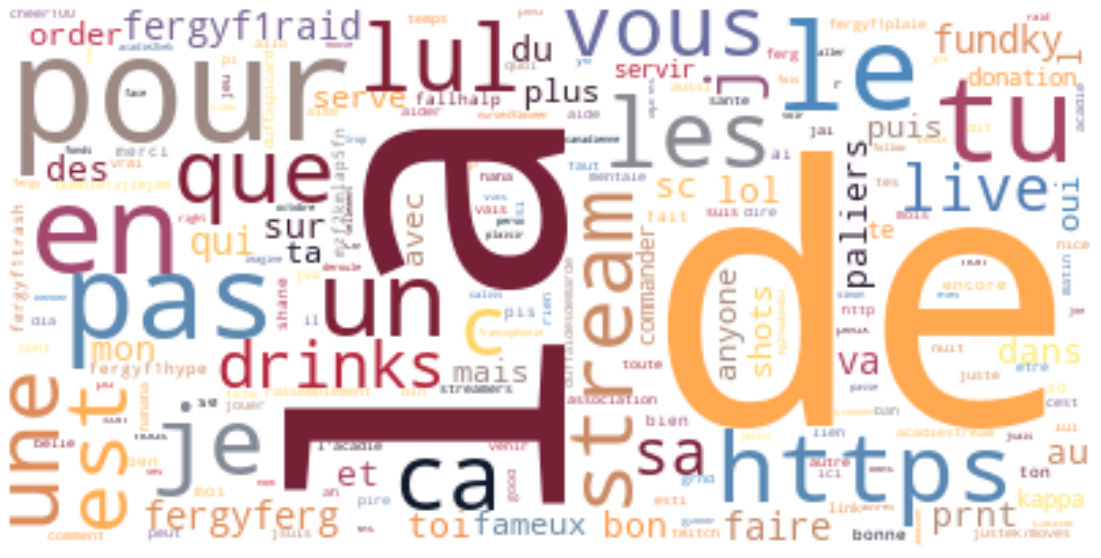

In [ ]:
hero.visualization.wordcloud(chat_df['clean_messages'], font_path = None, width = 400, height = 200, max_words=200, 
                             mask=None, contour_width=0, 
                             contour_color='PAPAYAWHIP', background_color='WHITE', 
                             relative_scaling='auto', colormap=None, return_figure=False)

Now, we need to extract variables from the chat, merge to video_df.

In [ ]:
 = pd.merge(video_df, temp,  how='left', left_on=['video_url'], right_on = ['video_url'])

In [ ]:
# This will save the notebook to the workspace if you're using Colab. Need to download to local or drive, then upload to github if want to use this later..
chat_df.to_csv('chatdf10112022.csv')

### Below are drafts. Ignore those! Different input files.

Parse

In [ ]:
# No need for this anymore.
## parse chat file
def get_chat_dataframe(file):
    data = []
    with open(file, 'r', encoding='utf-8') as f:
        lines = f.read().split('\n')
        for line in lines:
            #print(line)
            
            time_logged = line.split('UTC')[0][1:].strip()
            #time_logged = datetime.strptime(time_logged,'%Y-%m-%d-%H:%M:%S')
            #print(time_logged)
            
            username_message = line.split(']')[1:]
            username_message = '—'.join(username_message).strip()
            #print(username_message)
            try:
                temp = username_message.split(":")
                username = temp[0]
                message = temp[1]
            except IndexError:
                username = temp[0]
                message = '-'
            #print(username)
            #print(message)
            
            d = {'dt': time_logged,
                 'username': username,
                 'message': message
                    }
            data.append(d)
            
    return pd.DataFrame().from_records(data)

In [ ]:
## This is an example
chat_df = get_chat_dataframe('[1-21-22] Mongraal - Winning Duo Cash Cup With FaZe BL GUILD Flikk (Webcam Mic) - Chat.txt')

chat_df.head()

Cleaning and preprocessing

In [ ]:
## cleaning
import texthero as hero
from texthero import preprocessing

KeyError: ignored

In [ ]:
## customize a pipelifne
custom_pipeline = [preprocessing.lowercase, 
                   preprocessing.remove_punctuation,
                   preprocessing.remove_urls]

chat_df_temp = hero.clean(chat_df['message'])

NameError: ignored

In [ ]:
# Custom STOPWORDS removal -- Need to think about this.Could use the cloud as below 
from texthero import stopwords
default_stopwords = stopwords.DEFAULT
custom_stopwords = default_stopwords.union(set(['yo','play',"twitch","make", "use", "thank", "content", "good", "use",
                                                "think", "need", "harrisheller", "like", "stream",
                                               "kekw","catjam","tim","timthetatman","tatkevinh",
                                               "wipz","docspin","pog","tatlove","lol","lul","omegalul",
                                               "biblethump","clap","tathypers","pepeja","kappa","tattopd","ppsmoke",
                                               "pepelaugh","gopackgo","gachihyper","tatkevinh", "wipz",
                                               "pausechamp","yep","lmao","jack","lulw","monkaw","kreygasm",
                                               "pepega","peped","foxsalt","pogchamp","xqcn","get","back",
                                               "tattuff","tatfat","tatpumpkin","lmao","sadge","sippy",
                                               "pogu","poggers","consolecd","widepeepohappy","pogu","tategg2",
                                               "modcheck","timmy","tathmm","tats","got","com","babyrage",
                                               "xqcp","tatw","pokiw","know", "thats","pepocd","tatafk",
                                               "4weird","tatkkevin", "tatblanket","tatglam","tategg1","wutface",
                                               "blobdance", "kapp","tatbruh","kappapride","facebaby","xqc",
                                               "xqcm","bora","hyperclap","tatlit","5head","gachibass", "go", "ur",
                                                "yes","going","would","im","oh","dez","taty","tk","u","sg", "dont",
                                                "hey","hf","look","anita","anitaheart","leeper","anitahey",
                                                "anitadab","anitadoubt","anitahands", "anitalul","anitapog","anitasword",
                                                "anitaprime","anitafeels","residentsleeper","anitapride","anital",
                                                "anitabiscuit", "thing","widepeeposad","anitahype","among", "lesbianpride",
                                                "heyguys","seemsgood","notlikethis","hi","also","much","yeah",
                                               ])) ## Add as per requirement
# data = hero.remove_stopwords(data, default_stopwords)
chat_df_clean = hero.remove_stopwords(chat_df_temp, custom_stopwords)

In [ ]:
## visualize with wordcloud
hero.visualization.wordcloud(data, font_path = None, width = 400, height = 200, max_words=200, 
                             mask=None, contour_width=0, 
                             contour_color='PAPAYAWHIP', background_color='WHITE', 
                             relative_scaling='auto', colormap=None, return_figure=False)

In [ ]:
import gensim

# Tokenize
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(chat_df_clean))

print(data_words[:5])

In [ ]:
import spacy

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only Noun, Adjective, Verb, Adverb
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:50])

LDA

In [ ]:
# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

# Plotting tools
# !pip install -U pyLDAvis
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Word-Document Matrix
# This converts a collection of text documents to a matrix of token counts. 
# A document-term matrix or term-document matrix is a mathematical matrix that describes the frequency of terms that occur in a collection of documents. 
# In a document-term matrix, rows correspond to documents in the collection and columns correspond to terms. 

vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10,                        # minimum number occurences of a word required
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}')  # num of characters > 3
                            

data_vectorized = vectorizer.fit_transform(data_lemmatized)

In [ ]:
# Build LDA model with Sklearn

lda_model = LatentDirichletAllocation(n_components=15,               # Number of topics
                                      max_iter=10,                   # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,              # Random state
                                      batch_size=128)                # n docs in each learning iter
                                            
                                      
lda_output = lda_model.fit_transform(data_vectorized)

print(lda_model)  # Model attributes

In [ ]:
#Evaluate model quality

# Log Likelihood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp((-1) * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))

In [ ]:
# Grid Search for Best LDA Model
# Grid search is a tuning technique that attempts to compute the optimum values of hyperparameters. 
# It is an exhaustive search that is performed on a the specific parameter values of a model. The model is also known as an estimator.
# This is computationally expensive and usually takes time... 

from sklearn.model_selection import GridSearchCV

# Define Search Param
params = {'n_components': [5, 10, 15,20], 'learning_decay': [.5, .7, .9]}

# Model
lda = LatentDirichletAllocation()

# Grid Search
model = GridSearchCV(lda, param_grid=params)

# Perform Grid Search
model.fit(data_vectorized)

In [ ]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

In [ ]:
# Reflections:
# how important and how frequent certain words are in the corpus - what themes/etc. may emerge. 
# Show top n keywords for each topic

def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=10)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords